In [47]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
from pyspark.sql.functions import countDistinct
from pyspark.sql import functions as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.appName('Model Evaluation').getOrCreate()

In [3]:
spark

In [4]:
# file path
file_path = 'data/bank-full.csv'

In [5]:
# reading the data:
data = spark.read.csv(file_path, inferSchema=True, header=True, sep=';')

In [6]:
data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



In [11]:
def assemble_vector(df, features, target):
    stages = []
    
    assembler = VectorAssembler(inputCols=features, outputCol='features')
    str_indexer = StringIndexer(inputCol=target, outputCol='label')
    stages += [assembler, str_indexer]
    
    selected_cols = ['label', 'features'] + features
    pipeline = Pipeline(stages=stages)
    assemble_model = pipeline.fit(df)
    df = assemble_model.transform(df).select(selected_cols)
    return df

In [13]:
# selecting columns for vector assembler:
target = 'y'
logreg_df = data.select(['age', 'balance', 'day', 'duration',
                       'campaign', 'pdays', 'previous', 'y'])

features = logreg_df.columns
features.remove(target)

In [14]:
target, features

('y', ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'])

In [16]:
# assembling the vectors:
assembled_df = assemble_vector(data, features, target)

In [17]:
assembled_df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)



## Train/Test Split

#### Option 1: Using `randomSplit()`

In [18]:
train, test = assembled_df.randomSplit([0.7, 0.3], seed=42)

In [22]:
# Shape of the train and test datasets:
print(f"Train shape: {train.count(), len(train.columns)}")
print(f"Test shape: {test.count(), len(test.columns)}")

Train shape: (31750, 9)
Test shape: (13461, 9)


#### Option 2: Using the Pyspark ML `tuning` library

In [24]:
# model initialization:
lr = LogisticRegression(maxIter=10, featuresCol='features', labelCol='label')

In [28]:
# model parameters to try:

param_grid = (ParamGridBuilder()
              .addGrid(lr.regParam, [0.1, 0.01])
              .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
              .build())

In [31]:
# splitting the data into 70-30 split:

train_valid_clf = TrainValidationSplit(estimator=lr,  # model to use
                                      estimatorParamMaps=param_grid,  # list of parameters
                                      evaluator=BinaryClassificationEvaluator(),  # model evaluator 
                                      trainRatio=0.7)  # training ratio

In [32]:
# fitting the model:

model = train_valid_clf.fit(assembled_df)

#### Option 3: Using Stratified Sampling

In [33]:
# splitting data according to label:
zero_df = assembled_df.filter(assembled_df['label'] == 0)
one_df = assembled_df.filter(assembled_df['label'] == 1)

In [34]:
# splitting data into train and test:
train_zero, test_zero = zero_df.randomSplit([0.7, 0.3], seed=42)
train_one, test_one = one_df.randomSplit([0.7, 0.3], seed=42)

In [35]:
# Union Datasets:
train = train_zero.union(train_one)
test = test_zero.union(test_one)

In [36]:
# checking shape:
print(f"Train Shape: {train.count(), len(train.columns)}")
print(f"Test Shape: {test.count(), len(test.columns)}")

Train Shape: (31788, 9)
Test Shape: (13423, 9)


In [38]:
# Counting labels in Train and Test:
print('Number of zeros and ones in training data:')
print(train.filter(train['label'] == 0).count(), train.filter(train['label'] == 1).count())

print('\nNumber of zeros and ones in testing data:')
print(test.filter(test['label'] == 0).count(), test.filter(test['label'] == 1).count())

Number of zeros and ones in training data:
28029 3759

Number of zeros and ones in testing data:
11893 1530


## Holdout/Out of Time
- This technique is to reduce the ***SAMPLING BIAS***.
- Sampling Bias happens when the data is skewed towards one segment of the population and does not account for the overall segments in the population.
- ***Holdout/Out of Time or Cross-Validation*** can be used to reduce the SAMPLING BIAS.

In [39]:
# creating train, test and holdout:
train, test, holdout = assembled_df.randomSplit([0.7, 0.2, 0.1], seed=42)

In [40]:
# checking the number of records in each set:
train.count(), test.count(), holdout.count()

(31750, 8926, 4535)

**`Out of Time` Dataset**
- Imagine you are predicting some retail sales and are using November’s data. Due to Thanksgiving, the store put out a huge discount, and sales increased by x percent. When you use this data to build a model and predict sales for the rest of the month, you might get a model that does not account for the holiday discount. This is called a sampling bias.
- Example: In the retail sales prediction example above, November would be train/test/holdout and some other month would be *Out of Time* dataset.
- Industry Practice recommends we have at lest two *Out of Time* samples to validate our models.

## Population Stability Index
- Another recommendation to avoid SAMPLING BIAS and to achieve a stable model is to perform Population Stability Index(PSI) check on all the variables/features accross the datasets (train/test/holdout/out of time).
- We pick the best variables with high feature importance and low variability **(low PSI)**
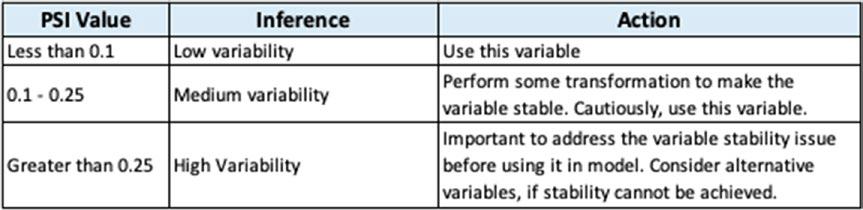

## K-Fold Cross Validation
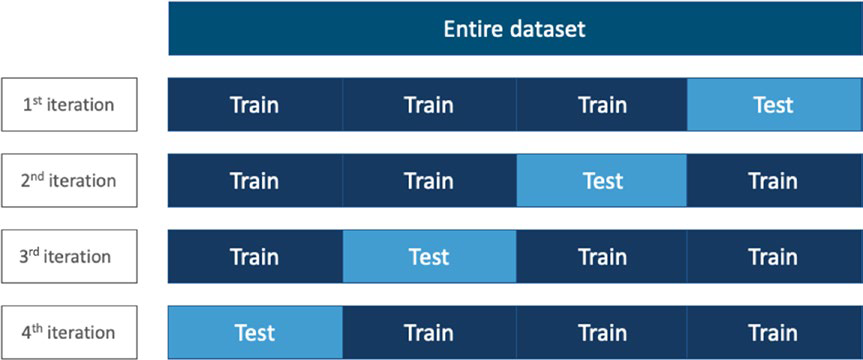

- Another way to reduce SAMPLING BIAS is to use ***k-fold Cross-Validation***.
- In a k-fold cross-validation, every datapoint is used for both training and testing the model. At a given point in time, each datapoint could be either in training or testing, but not both. Therefore, the training and testing data are not static, and thus the sampling bias is minimized.
<br><br>
- We can perform k-fold Cross-Validation using *tuning* library ---> `pyspark.ml.tuning.CrossValidator`

In [42]:
# creating the model:
lr = LogisticRegression(maxIter=10, featuresCol='features', labelCol='label')

In [44]:
# model parameters:
param_grid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.01])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .build())

In [45]:
# creating the cross validation:
crossval_clf = CrossValidator(estimator=lr,  # model to be used
                             estimatorParamMaps=param_grid,  # parameters to be used
                             numFolds=3,  # number of folds
                             evaluator=BinaryClassificationEvaluator())

In [46]:
# fitting the crossval_clf to our data:
model = crossval_clf.fit(assembled_df)

## Leave-one-out Cross-Validation
- It is a variation of the k-fold Cross-Validation. 
- The idea is to use a single observation as the test set and the remaining records as the training set.
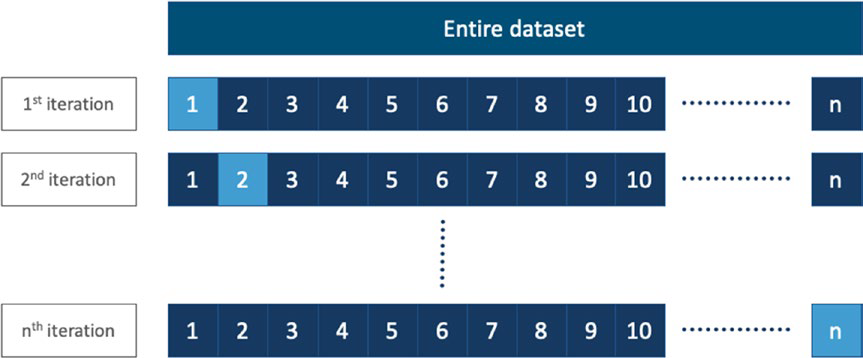
- This method is computationaly very expensive as it needs to be run for n time (n is the number of records) for each hyperparameter we set.

## Leave-one-group-out Cross-Validation
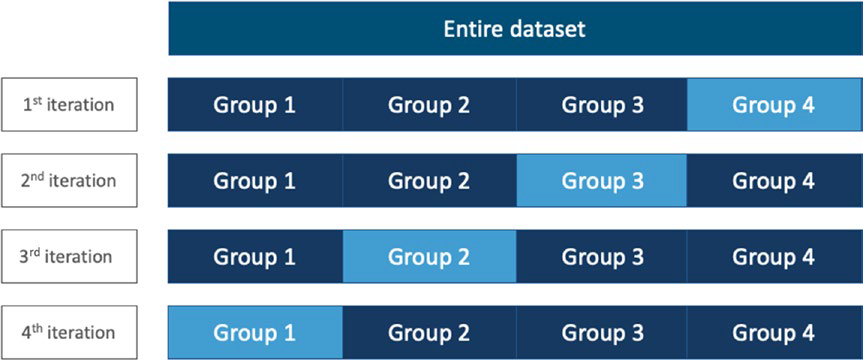
<br><br>
- This method is not available in PySpark, so we define our own methd to solve this problem

In [50]:
df = spark.read.csv(file_path, inferSchema=True, header=True, sep=';')

In [51]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



In [52]:
df = df.withColumn('label', F.when(F.col("y") == 'yes', 1).otherwise(0))
df = df.drop('y')
df = df.select(['education', 'age', 'balance', 'day', 'duration',
                'campaign', 'pdays', 'previous', 'label'])

features_list = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [53]:
# assembling the features into one column:
def assemble_vector(df, features_list, target, group):
    stages = []
    assembler = VectorAssembler(inputCols=features, outputCol='features')
    stages = [assembler]
    
    selected_cols = [group, target, 'features']
    pipeline = Pipeline(stages=stages)
    assemble_model = pipeline.fit(df)
    df = assemble_model.transform(df).select(selected_cols)
    return df

In [55]:
# applying the function to our df:
joined_df = assemble_vector(df, features_list, 'label', 'education')

In [56]:
# finding the groups to apply cross-validation accross
groups = list(joined_df.select('education').toPandas()['education'].unique())

In [57]:
groups

['tertiary', 'secondary', 'unknown', 'primary']

In [62]:
# leave-one-group-out function:
def leave_one_group_out(df, var_name, group):
    train_score = []
    test_score = []
    
    for i in groups:
        train = df.filter(df[var_name] != i)  # training on all groups except one.
        test = df.filter(df[var_name] == i)  # testing on one group
        
        # model initialization
        lr = LogisticRegression(maxIter=10, featuresCol='features', labelCol='label')
        evaluator = BinaryClassificationEvaluator(labelCol='label', 
                                                 rawPredictionCol='rawPrediction',
                                                 metricName='areaUnderROC')
        
        # fitting the model:
        model = lr.fit(train)
        # making predictions:
        predict_train = model.transform(train)
        predict_test = model.transform(test)
        
        train_score.append(evaluator.evaluate(predict_train))
        test_score.append(evaluator.evaluate(predict_test))
        
        print(f"{str(i)} Group")
        print(f"Train AUC: {train_score[-1]}")
        print(f"Test AUC: {test_score[-1]}")
        print("-" * 50)
    
    print("Final evaluation for the model:")
    print(f"Training Score: {np.mean(train_score)}")
    print(f"Testing Score: {np.mean(test_score)}")

In [63]:
# calling the function:
leave_one_group_out(joined_df, 'education', groups)

tertiary Group
Train AUC: 0.8344322736604696
Test AUC: 0.8084326104664004
--------------------------------------------------
secondary Group
Train AUC: 0.8195531518202662
Test AUC: 0.8303735759916921
--------------------------------------------------
unknown Group
Train AUC: 0.82523988559768
Test AUC: 0.8053800128566462
--------------------------------------------------
primary Group
Train AUC: 0.8203514433256405
Test AUC: 0.8512218690366159
--------------------------------------------------
Final evaluation for the model:
Training Score: 0.8248941886010142
Testing Score: 0.8238520170878386
